In [1]:
import matplotlib.image as image
from matplotlib import pyplot as plt
import pylab
%matplotlib inline
import requests
import re
import json
import pandas as pd
from selenium import webdriver
from time import sleep
headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:45.0) Gecko/20100101 Firefox/45.0'}

В первую очередь, научимся извлекать информацию об отдельно взятом матче. Сделать это легко, она содержится в html-коде страницы:

In [2]:
def get_match_info(match_url):
    response = requests.get(match_url,headers=headers)
    regex = re.compile("var matchCentreData = (\{.+\});\r\n        var matchCentreEventTypeJson", re.S)
    match = re.search(regex, response.text)
    match_id = re.findall(r'\d+', match_url)[0]
    match_dict = json.loads(match.groups(1)[0])
    match_dict['match_id'] = match_id
    
    teams_info = re.findall('matchHeader.load\(\[(.+)\]\r', response.text)[0].split(',')
    match_dict['home_team_name'] = teams_info[2][1:-1]
    match_dict['away_team_name'] = teams_info[3][1:-1]

    return match_dict

Результат - огромный список с информацией о каждом действии, произошедшим по ходу матча. Каждому событию поставлены в соответствие несколько чисел из списка *satisfiedEventsTypes*, характеризующих его тип (например, 7 значит, что данное событие - удар в штангу, 11 - удар правой ногой и т.д.). Например, 'satisfiedEventsTypes': [90, 116, 29, 34, 36, 215, 217] говорит о том, что рассматриваемое событие - точный пас назад, сделанный во второй трети поля. 

Так как нас интересуют только удары, будем обрабатывать только те события, содержащие в этом списке 9 (событие "shotsTotal"):

In [3]:
def parse_shots_from_match(match_info):
    
    match_id = match_info['match_id']
    home_id = match_info['home']['teamId']
    away_id = match_info['away']['teamId']
    player_ids = match_info['playerIdNameDictionary']
    
    shots = []
    
    for event in match_info['events']:
        if 9 in event['satisfiedEventsTypes']:
            minute = event['minute']
            
            player_id = str(event['playerId'])
            player_name = player_ids[player_id]
            x_coord = event['x']
            y_coord = event['y']
        
            goalMouthY = ''
            goalMouthZ = ''
            try:
                goalMouthY = event['goalMouthY']
                goalMouthZ = event['goalMouthZ']
            except:
                pass
        
            is_big_chance = 0
            is_from_corner = 0
            is_freekick = 0
            is_penalty = 0
            if 'qualifiers'  in event:
                for q in event['qualifiers']:
                    if q['type']['displayName'] == 'BigChance':
                        is_big_chance = 1
                    if q['type']['displayName'] == 'FromCorner':
                        is_from_corner = 1
                    if q['type']['displayName'] ==  'DirectFreekick':
                        is_freekick = 1
                    if q['type']['displayName'] == 'Penalty':
                        is_penalty = 1
        
            is_open_play = int(3 in event['satisfiedEventsTypes'])
            is_counter = int(4 in event['satisfiedEventsTypes'])
            is_set_piece = int(5 in event['satisfiedEventsTypes'])
            is_goal = int(('isGoal' in event) and (event['isGoal']==True))
            is_shot_on_target = int(8 in event['satisfiedEventsTypes'])
            is_blocked = int(10 in event['satisfiedEventsTypes'])
        
            shot_type = 0
            if 11 in event['satisfiedEventsTypes']:
                shot_type = 1
            if 12 in event['satisfiedEventsTypes']:
                shot_type = 1
            if 13 in event['satisfiedEventsTypes']:
                shot_type = 2
        
            shots.append([match_id, event['teamId'], player_id, player_name, minute, x_coord, y_coord, goalMouthY, goalMouthZ,
                          shot_type, is_big_chance, is_from_corner, is_open_play, is_counter, is_set_piece, is_freekick, 
                          is_penalty, is_shot_on_target, is_blocked, is_goal])

    return shots

Нужно уметь представлять данные об ударах в удобном виде:

In [4]:
def represent(shots_list):
    return pd.DataFrame(shots_list, columns=['match_id', 'team_id', 'player_id', 'player_name', 'minute', 'x', 'y', 
                'goalMouthY', 'goalMouthZ', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 
                'is_set_piece', 'is_freekick', 'is_penalty', 'is_on_target', 'is_blocked', 'is_goal'])

Итак, теперь мы умеем делать все необходимое для анализа отдельно выбранного матча. Однако нам предстоит обрабатывать тысячи игр, так что необходимо уметь получить ссылки на множество матчий одним действием. Так как whoscored.com динамически подгружает информацию о матчах, лучший способ это сделать - воспользоваться модулем Selenium:

In [5]:
def get_tournament_urls(tournament_url):
    driver = webdriver.Chrome('/home/saint/Рабочий стол/chromedriver')
    driver.get(tournament_url)
    
    match_urls = []
    
    while True:
        month = driver.find_elements_by_class_name("text")[4].text
        matches = driver.find_elements_by_class_name("result-1")
        for match in matches:
            match_urls.append(match.get_attribute('href'))
        driver.find_element_by_xpath("""//*[@id="date-controller"]/a[1]""").click()
        month_new = driver.find_elements_by_class_name("text")[4].text
        if month_new == month:
            break
        month = month_new
        sleep(2)
    return match_urls

In [6]:
matches = get_tournament_urls('https://www.whoscored.com/Regions/108/Tournaments/5/Seasons/6461/Stages/14014/Fixtures/Italy-Serie-A-2016-2017')

In [367]:
from tqdm import tqdm
shots = []
for match in tqdm(matches):
    shots += parse_shots_from_match(get_match_info(match))
    sleep(0.5)

100%|██████████| 306/306 [14:44<00:00,  2.39s/it]


На всякий случай реализуем возможность визуализации точек, с которых и в которые был нанесен удар:

In [7]:
from matplotlib import patches
def goalMouth_map(coord_list, is_goal_list):

    fig,ax = plt.subplots(1)
    fig.set_size_inches(15, 3.9, forward=True)

    pylab.ylim([0,55])
    pylab.xlim([-10,10])

    rect = patches.Rectangle((-4.9,0),9.8,38.5,linewidth=7,edgecolor='k',facecolor='none')
    ax.add_patch(rect)

    for c, shot in enumerate(coord_list):
        color = '.g' if is_goal_list[c] == 1 else '.r'
        plt.plot(50-shot[0], shot[1], color )
    plt.show()

In [8]:
def shots_map(coord_list, is_goal_list, is_home_list, xG_list = False, score='', home_team_name='', away_team_name='',
             xG_score=''):
    PITCH_LENGTH = 152
    
    fig,ax = plt.subplots(1)
    ax.set_facecolor('#65AA1F')
    fig.set_size_inches(13, 15, forward=True)
    plt.gca().set_aspect('equal', adjustable='box')
    pylab.ylim([0,110])
    pylab.xlim([0,PITCH_LENGTH])

    plt.plot([50*PITCH_LENGTH/100, 50*PITCH_LENGTH/100], [0, 100], 'k-', lw=2)
    plt.plot([0, 16.2*PITCH_LENGTH/100], [20, 20], 'k-', lw=2)
    plt.plot([0, 16.2*PITCH_LENGTH/100], [80, 80], 'k-', lw=2)
    plt.plot([16.2*PITCH_LENGTH/100, 16.2*PITCH_LENGTH/100], [20, 80], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 83.8*PITCH_LENGTH/100], [20, 20], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 83.8*PITCH_LENGTH/100], [80, 80], 'k-', lw=2)
    plt.plot([83.8*PITCH_LENGTH/100, 83.8*PITCH_LENGTH/100], [20, 80], 'k-', lw=2)
    plt.plot([0, 5.5*PITCH_LENGTH/100], [36.33, 36.33], 'k-', lw=2)
    plt.plot([0, 5.5*PITCH_LENGTH/100], [63.67, 63.67], 'k-', lw=2)
    plt.plot([5.5*PITCH_LENGTH/100, 5.5*PITCH_LENGTH/100], [36.33, 63.67], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 94.5*PITCH_LENGTH/100], [36.33, 36.33], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 94.5*PITCH_LENGTH/100], [63.67, 63.67], 'k-', lw=2)
    plt.plot([94.5*PITCH_LENGTH/100, 94.5*PITCH_LENGTH/100], [36.33, 63.67], 'k-', lw=2)
    plt.plot([0, 0], [44.54, 55.46], 'k-', lw=5)
    plt.plot([100*PITCH_LENGTH/100, 100*PITCH_LENGTH/100], [44.54, 55.46], 'k-', lw=5)
    plt.plot(11.5*PITCH_LENGTH/100,50, '.k')
    plt.plot(88.5*PITCH_LENGTH/100,50, '.k')
    plt.plot([0, 100*PITCH_LENGTH/100], [100, 100], 'k-', lw=2)
    circle=plt.Circle((50*PITCH_LENGTH/100,50),14.5, fill=False)
    ax.add_artist(circle)
    
    rect = patches.Rectangle((0,100),PITCH_LENGTH,10,linewidth=1,color='w')
    ax.add_patch(rect)
    
    plt.text(15,104,home_team_name, size=20, horizontalalignment='left')
    plt.text(PITCH_LENGTH-15,104,away_team_name, size=20, horizontalalignment='right')
    plt.text(PITCH_LENGTH/2,106,score, size=15, horizontalalignment='center')
    plt.text(PITCH_LENGTH/2,102,xG_score, size=15, horizontalalignment='center')
    
    for c, shot in enumerate(coord_list):
        color = '.g' if is_goal_list[c] == 1 else '.r'
        if type(xG_list) == bool:
            markersize = 30
        else:
            markersize = 50*np.sqrt(xG_list[c])
        if is_home_list[c] == 0:
            x = shot[0]*PITCH_LENGTH/100
            y = shot[1]
        else:
            x = (100-shot[0])*PITCH_LENGTH/100
            y = 100-shot[1]
        plt.plot(x, y, color, markersize=markersize, markeredgecolor='k')
    plt.savefig('testplot.png', bbox_inches='tight', pad_inches=0)
    plt.show()

In [22]:
from os import listdir
seasons = []
for file in listdir('/home/saint/Рабочий стол/Football Analytics/ignatov/data'):
    seasons.append(pd.read_csv('data/'+file))
a = pd.concat(seasons)

Загрузим обученную модель xG и попробуем осуществить предсказания:

In [10]:
from sklearn.externals import joblib
lr = joblib.load('LogisticRegression.pkl') 

In [11]:
def get_shot_xG(shot):
    return lr.predict_proba(shot.reshape(1,-1))[:,1][0]

In [12]:
def get_list_xG(shots):
    xG_list = []
    for shot in shots:
        xG_list.append(get_shot_xG(shot))
    return xG_list

In [13]:
def get_match_xG(match_url):
    match_info = get_match_info(match_url)
    
    score = match_info['score'] 
    home_team_id = match_info['home']['teamId']
    away_team_id = match_info['away']['teamId']
    home_team_name = match_info['home_team_name']
    away_team_name = match_info['away_team_name']

    df = represent(parse_shots_from_match(match_info))
    shot_data = df[['team_id', 'x', 'y', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter',
                    'is_set_piece', 'is_freekick']]
    shot_data.is_copy = False
    shot_data['distance'] = np.sqrt((100-shot_data['x'])**2+((100-shot_data['y'])/100*63)**2)
    shot_data['y'] = abs(shot_data['y']-50)
    shot_data = pd.get_dummies(data=shot_data, columns=['shot_type']).drop('team_id', axis=1).values
    df['xG'] = get_list_xG(shot_data)

    home_pens = df[(df['is_penalty'] == 1) & (df['team_id'] == home_team_id)]['is_penalty'].sum()
    away_pens = df[(df['is_penalty'] == 1) & (df['team_id'] == away_team_id)]['is_penalty'].sum()
    df_no_pen = df[df['is_penalty'] == 0]
    home_xG = df_no_pen[df_no_pen['team_id'] == home_team_id]['xG'].sum()
    away_xG = df_no_pen[df_no_pen['team_id'] == away_team_id]['xG'].sum()
    xG_score = '(%0.2f ' % (home_xG)
    if home_pens != 0:
        xG_score += '(+%d pen) ' % (home_pens)
    xG_score += ': %0.2f' % (away_xG)
    if away_pens != 0:
        xG_score += ' (+%d pen)' % (away_pens)
    xG_score += ')'

    shots_info = df_no_pen[['x', 'y', 'is_goal', 'xG', 'team_id']]
    shots_info['home_team'] = (shots_info['team_id'] == home_team_id).astype(int)
    shots_info = shots_info.values
    shots_map(shots_info[:,:2], shots_info[:,2], shots_info[:,5], shots_info[:,3], score=score,
              home_team_name=home_team_name, away_team_name=away_team_name, xG_score=xG_score)
    return df

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


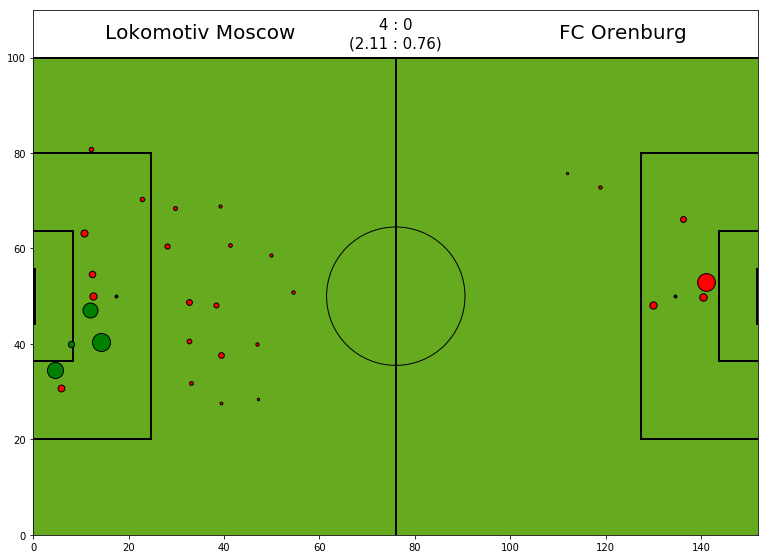

In [14]:
import numpy as np
shots = get_match_xG('https://www.whoscored.com/Matches/1083840/Live/Russia-Premier-League-2016-2017-Lokomotiv-Moscow-FC-Orenburg')

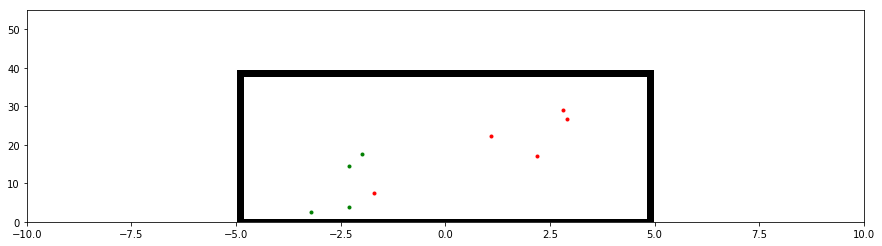

In [23]:
sh_t = shots[shots['is_on_target'] == 1][['goalMouthY', 'goalMouthZ', 'is_goal']].values
goalMouth_map(sh_t[:,:2], sh_t[:,2])